Start with autoreload magic; this reloads modules automatically before entering the execution of code and thus enabled development in modules like util.py

In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import os
from glob import glob

import numpy as np
import xarray as xr
import pandas as pd

import matplotlib.pyplot as plt

import config

import util

In [12]:
obspack_dir = "/glade/work/mclong/sno-analysis/obspack_co2_1_GLOBALVIEWplus_v7.0_2021-08-18/data/nc"
obspack_filenames = [ # now including aircraft
    f"{obspack_dir}/co2_alt_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_brw_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_cba_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_cgo_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_kum_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_ljo_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_mlo_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_psa_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_smo_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_spo_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_hip_aircraft-insitu_59_allvalid.nc",
    f"{obspack_dir}/co2_orc_aircraft-insitu_3_allvalid-merge10.nc",
    f"{obspack_dir}/co2_tom_aircraft-insitu_1_allvalid.nc",
    f"{obspack_dir}/co2_gould_shipboard-insitu_1_allvalid.nc",
    f"{obspack_dir}/co2_aoa_aircraft-flask_19_allvalid.nc",
]
 
cesm_obspack_filenames = [ # special hanlding required
    f"{obspack_dir}/cam6327_sd.apo-forward.001.cam_obspack.alt.nc",
    f"{obspack_dir}/cam6327_sd.apo-forward.001.cam_obspack.brw.nc",
    f"{obspack_dir}/cam6327_sd.apo-forward.001.cam_obspack.cba.nc",
    f"{obspack_dir}/cam6327_sd.apo-forward.001.cam_obspack.cgo.nc",
    f"{obspack_dir}/cam6327_sd.apo-forward.001.cam_obspack.kum.nc",
    f"{obspack_dir}/cam6327_sd.apo-forward.001.cam_obspack.ljo.nc",
    f"{obspack_dir}/cam6327_sd.apo-forward.001.cam_obspack.mlo.nc",
    f"{obspack_dir}/cam6327_sd.apo-forward.001.cam_obspack.psa.nc",
    f"{obspack_dir}/cam6327_sd.apo-forward.001.cam_obspack.smo.nc",
    f"{obspack_dir}/cam6327_sd.apo-forward.001.cam_obspack.spo.nc",
    f"{obspack_dir}/co2_hip_aircraft-insitu_59_allvalid_cam.nc",
    f"{obspack_dir}/co2_orc_aircraft-insitu_3_allvalid-merge10_cam.nc",
    f"{obspack_dir}/co2_tom_aircraft-insitu_1_allvalid_cam.nc",
    f"{obspack_dir}/cam6327_sd.apo-forward.001.cam_obspack.gould.nc",
    f"{obspack_dir}/co2_aoa_aircraft-flask_19_allvalid_cam.nc",
]

obspack_files = {}
cesm_obspack_files = {}
station_list = []
for f1, f2 in zip(obspack_filenames,cesm_obspack_filenames):
    stn = os.path.basename(f1).split('_')[1]
    station_list.append(stn)
    obspack_files[stn] = os.path.basename(f1)
    cesm_obspack_files[stn] = os.path.basename(f2)

### Contribution details
- 11 surface files (stations and Gould) and 4 aircract files, with different naming conventions, included variables, and data types
- including land CO2 run (still to get)
- aircraft files also include pressure, surface pressure, temperature, humidity, hz wind, vt wind, potential temperature, and BL height
- also including 3D fields (one netcdf file per day)
- o2 in station files is in per meg (fix?)

In [13]:
sno_vars = [
    'apo_jena',
    'o2_cesm', 
    'co2_cesm', 
    'n2_cesm', 
    'o2_gk01r16',  
    'co2_somffn', 
    'n2_era', 
    'co2_oco2mip', 
    'co2_gridfed', 
    'o2_gridfed',   
] # without derived vars
# ordered to match indexing in modelsamplesensemble

X_O2 = 0.2094 

droot = "/glade/campaign/eol/raf/stephens/longcoll/apo-simulation-data/CAM-SD/required_obspack"

station_records = {}
for station in station_list:

    path = f"{droot}/{cesm_obspack_files[station]}"
    print(path)
    ds = xr.open_dataset(path)

    # get time as coordinate
    time = ds.time
    time.name = 'obs'
    ds['obs'] = time
    ds = ds.drop('time').rename({'obs': 'time'})

    # # get rid of missing value codes
    # _FillValue = -999999
    # for v in sno_vars:
    #     ds[v] = ds[v].where(ds[v] != _FillValue)

    # fix apparent scaling issue with co2_cesm
    ds['co2_cesm']=ds['co2_cesm']/2 

    # convert mole fraction to ppm
    for v in sno_vars:
        ds[v]=ds[v]*1E6
    
    # subtract off background value    
    for v in sno_vars:
        ds[v]=ds[v]-400.0 
   
    
   
    # fixed
    ## o2 and apo_jena variables currently in per meg - convert o2 back to ppm
    ## ds['apo_jena'] = ds['apo_jena']*X_O2
    #ds['o2_cesm'] = ds['o2_cesm']*X_O2
    #ds['o2_gk01r16'] = ds['o2_gk01r16']*X_O2
    #ds['o2_gridfed'] = ds['o2_gridfed']*X_O2

    ## convert apo_jena to per meg
    ##ds['apo_jena'] = ds['apo_jena']/X_O2 # already done in submission
    ds['apo_jena'] = ds['apo_jena']/X_O2
        
    # add derived APO variables
  
    ds['apo_cesm'] = util.compute_apo (
        o2=ds['o2_cesm'],
        co2=ds['co2_cesm'],
        n2=ds['n2_cesm']
    )

    ds['apo_diss'] = util.compute_apo (
        o2=ds['o2_gk01r16'],
        co2=ds['co2_somffn'],
        n2=ds['n2_era']
    )

    ds['apo_gridfed'] = util.compute_apo (
        o2=ds['o2_gridfed'],
        co2=ds['co2_gridfed'],
        n2=0.0
    )

    ds['apo_oco2mip'] = util.compute_apo (
        o2=ds['co2_oco2mip'] * -1.4,
        co2=ds['co2_oco2mip'],
        n2=0.0
    )

    ds.to_netcdf(f"inverse_model_obspack_files/CAM-SD/{obspack_files[station]}")
    
    station_records[station] = ds

/glade/campaign/eol/raf/stephens/longcoll/apo-simulation-data/CAM-SD/required_obspack/cam6327_sd.apo-forward.001.cam_obspack.alt.nc
/glade/campaign/eol/raf/stephens/longcoll/apo-simulation-data/CAM-SD/required_obspack/cam6327_sd.apo-forward.001.cam_obspack.brw.nc
/glade/campaign/eol/raf/stephens/longcoll/apo-simulation-data/CAM-SD/required_obspack/cam6327_sd.apo-forward.001.cam_obspack.cba.nc
/glade/campaign/eol/raf/stephens/longcoll/apo-simulation-data/CAM-SD/required_obspack/cam6327_sd.apo-forward.001.cam_obspack.cgo.nc
/glade/campaign/eol/raf/stephens/longcoll/apo-simulation-data/CAM-SD/required_obspack/cam6327_sd.apo-forward.001.cam_obspack.kum.nc
/glade/campaign/eol/raf/stephens/longcoll/apo-simulation-data/CAM-SD/required_obspack/cam6327_sd.apo-forward.001.cam_obspack.ljo.nc
/glade/campaign/eol/raf/stephens/longcoll/apo-simulation-data/CAM-SD/required_obspack/cam6327_sd.apo-forward.001.cam_obspack.mlo.nc
/glade/campaign/eol/raf/stephens/longcoll/apo-simulation-data/CAM-SD/require

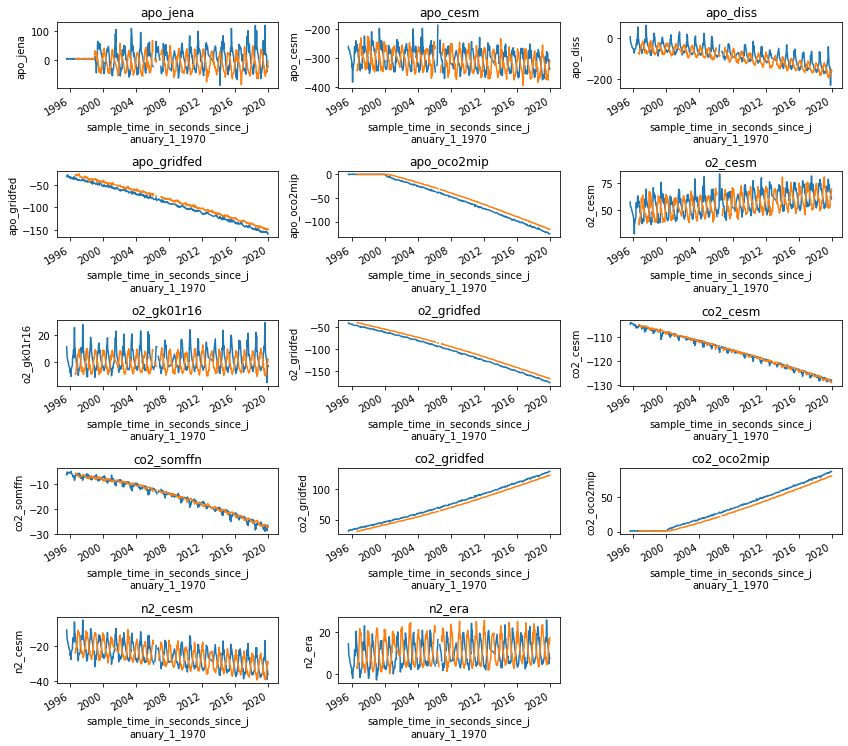

In [14]:
# plot timeseries

sno_vars = [
    'apo_jena',
    'apo_cesm',
    'apo_diss',
    'apo_gridfed',
    'apo_oco2mip',
    'o2_cesm', 
    'o2_gk01r16',  
    'o2_gridfed',   
    'co2_cesm', 
    'co2_somffn', 
    'co2_gridfed', 
    'co2_oco2mip', 
    'n2_cesm', 
    'n2_era', 
] # including derived vars

station_plot_list=['cba','psa']

n_plots = len(sno_vars)
ncol = int(np.sqrt(n_plots))
nrow = int(((n_plots / ncol) + n_plots % ncol))
fig, axs = plt.subplots(nrow, ncol, figsize=(12, 12), squeeze=False)

for n, v in enumerate(sno_vars):
    ip, jp = np.unravel_index(n, axs.shape)
    
    ax = axs[ip, jp]
    for stn in station_plot_list:
        station_records[stn][v].plot(ax=ax)
    ax.set_title(v)

plt.tight_layout();    

for n in range(n+1, nrow*ncol):
    ip, jp = np.unravel_index(n, (nrow, ncol))
    axs[ip, jp].remove()
    

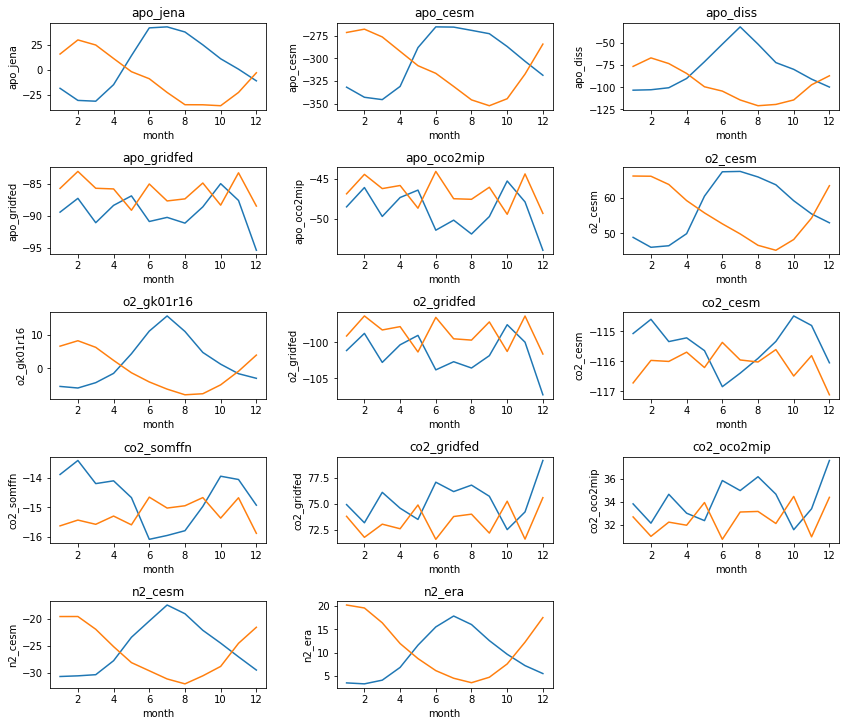

In [15]:
# seasonal climatology

fig, axs = plt.subplots(nrow, ncol, figsize=(12, 12), squeeze=False)

for n, v in enumerate(sno_vars):
    ip, jp = np.unravel_index(n, axs.shape)
    
    ax = axs[ip, jp]
    for stn in station_plot_list:
        ds_seas=station_records[stn][v].groupby('time.month').mean('time')
        ds_seas.plot(ax=ax)
    ax.set_title(v)

plt.tight_layout();    

for n in range(n+1, nrow*ncol):
    ip, jp = np.unravel_index(n, (nrow, ncol))
    axs[ip, jp].remove()
    